In [1]:
%matplotlib inline

from json import loads, dumps

from sklearn.linear_model import *
from sklearn.cross_validation import KFold

import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

from math import sqrt

from time import time

from scipy.sparse import csc_matrix

import matplotlib.pyplot as plt

MOVIE_DATA_LOC = '../data/movies.bigdata'

MOVIE_ACTOR_DATA_LOC = '../data/movie_casts.bigdata'
MOVIE_DIR_DATA_LOC = '../data/movie_directors.bigdata'
MOVIE_ACTOR_DIR_DATA_LOC = '../data/movie_actors_directors.bigdata'

CURRENTLY_USING = MOVIE_ACTOR_DIR_DATA_LOC

In [2]:
# read in movie data
movie_data = []
with open(MOVIE_DATA_LOC) as f:
    for line in f:
        movie_data.append(loads(line))

In [3]:
# read in movie actor data
movie_actor_data = []
with open(CURRENTLY_USING) as f:
    for line in f:
        movie_actor_data.append(tuple(line.rstrip().split(',')))

In [4]:
# mapping of actor_id to name
actor_name_mapping = {}

# mapping of actor_id to index
actor_index_mapping = {}

# mapping of movie_id to set(actor_ids)
movie_cast_mapping = {}

actor_last_index = 0
for entry in movie_actor_data:
    movie_ID, actor_ID, actor_name = entry
    if actor_ID not in actor_name_mapping:
        actor_name_mapping[actor_ID] = actor_name
    if actor_ID not in actor_index_mapping:
        actor_index_mapping[actor_ID] = actor_last_index
        actor_last_index += 1
    if movie_ID not in movie_cast_mapping:
        movie_cast_mapping[movie_ID] = set()
    movie_cast_mapping[movie_ID].add(actor_ID)
    
# mapping of movie_id to name
movie_name_mapping = {}

# mapping of movie_id to rating
movie_rating_mapping = {}

# mapping of movie_id to index
movie_index_mapping = {}

movie_last_index = 0
for entry in movie_data:
    try:
        movie_rating = float(entry['data']['rating'])
    except KeyError:
        movie_rating = -1. # sentinel value for indicating lack of rating
    movie_ID = entry['data']['tconst']
    movie_name = entry['data']['title']
    if movie_ID not in movie_name_mapping:
        movie_name_mapping[movie_ID] = movie_name
    if movie_ID not in movie_rating_mapping:
        movie_rating_mapping[movie_ID] = movie_rating
    if movie_ID not in movie_index_mapping:
        # needs to have a rating and a cast
        if (movie_rating_mapping[movie_ID] != -1.) and (movie_ID in movie_cast_mapping):
            # year filter
            movie_year = int(entry['data']['year'])
            if 0 <= movie_year:
                movie_index_mapping[movie_ID] = movie_last_index
                movie_last_index += 1

print len(actor_name_mapping), len(actor_index_mapping), len(movie_cast_mapping), len(movie_name_mapping), len(movie_rating_mapping), len(movie_index_mapping)

224127 224127 9756 9868 9868 9413


In [5]:
# combine actors and directors

# OUT = '../data/movie_actors_directors.bigdata'

# with open(OUT, 'w') as f:
#     with open(MOVIE_ACTOR_DATA_LOC, 'r') as actor_f:
#         for line in actor_f:
#             f.write(line)
#     with open(MOVIE_DIR_DATA_LOC, 'r') as dir_f:
#         for line in dir_f:
#             f.write(line)

In [6]:
# # make movie_directors.bigdata

# OUT = '../data/movie_directors.bigdata'

# with open(OUT, 'w') as f:
#     for entry in movie_data:
#         movie_ID = entry['data']['tconst']
#         if 'directors_summary' in entry['data']:
#             for director in entry['data']['directors_summary']:
#                 director_ID = director['name']['nconst']
#                 director_name = director['name']['name'].encode('ascii', 'ignore')
#                 f.write('%s,%s,%s\n' % (movie_ID, director_ID, director_name))

In [7]:
def rmse(test_classes_true, test_classes_pred):
    return sqrt(mean_squared_error(test_classes_true, test_classes_pred))

In [8]:
def predict(train_feature_matrix, train_classes, test_feature_matrix, test_classes_real, classifier):
    classifier.fit(train_feature_matrix, train_classes)
    test_classes_pred = classifier.predict(test_feature_matrix)
    return test_classes_pred, test_classes_real

In [9]:
# cross validation predict
def cv_predict(feature_matrix, classes, classifier, k):
    kf = KFold(len(classes), n_folds=k)
    results = []
    for train, test in kf:
        train_feature_matrix = feature_matrix[train]
        train_classes = classes[train]
        test_feature_matrix = feature_matrix[test]
        test_classes_real = classes[test]
        results.append(predict(train_feature_matrix, train_classes, test_feature_matrix, test_classes_real, classifier))
    return results

In [10]:
# prepare binary feature matrix, rows = movies, columns = actors
matrix = np.empty(shape=(len(movie_index_mapping), len(actor_index_mapping)), dtype=np.uint8)
matrix.fill(0)

ratings = np.empty(shape=len(movie_index_mapping), dtype=float)

for movie_ID in movie_index_mapping:
    movie_index = movie_index_mapping[movie_ID]
    for actor_ID in movie_cast_mapping[movie_ID]:
        actor_index = actor_index_mapping[actor_ID]
        matrix[movie_index, actor_index] = 1
    ratings[movie_index] = movie_rating_mapping[movie_ID]
    
smatrix = csc_matrix(matrix)

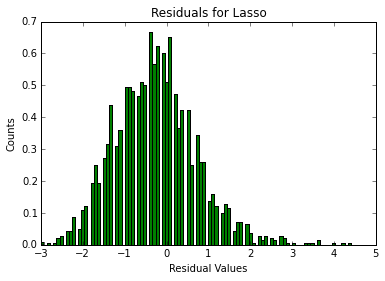

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute='auto', tol=0.0001,
   warm_start=False)
1.15152435201 -0.244345897398 19.0780000687


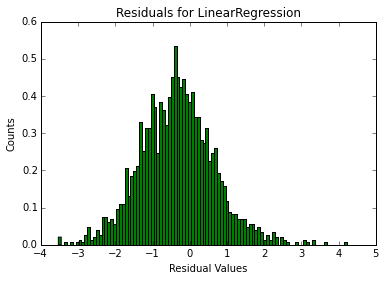

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)
1.11181678613 -0.158911134899 16.4070000648


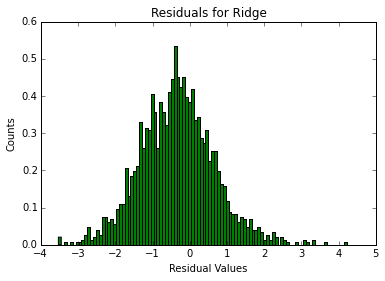

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001)
1.11157081265 -0.158417356427 4.21999979019


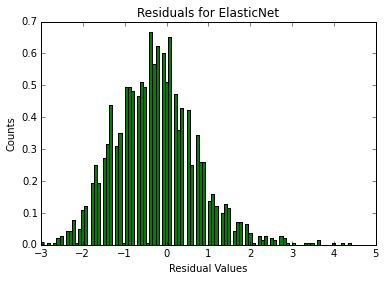

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute='auto',
      tol=0.0001, warm_start=False)
1.15143011956 -0.24416238028 30.359000206


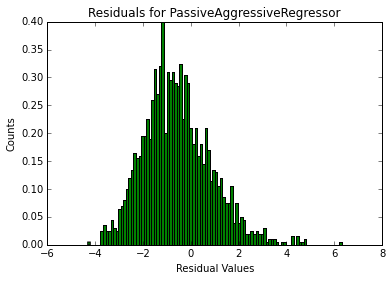

PassiveAggressiveRegressor(C=1.0, class_weight=None, epsilon=0.1,
              fit_intercept=True, loss='epsilon_insensitive', n_iter=5,
              random_state=None, shuffle=False, verbose=0,
              warm_start=False)
1.80478744558 -2.38367311706 0.913999795914


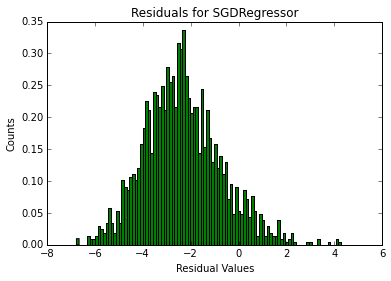

SGDRegressor(alpha=0.01, epsilon=0.1, eta0=0.01, fit_intercept=True,
       l1_ratio=0.15, learning_rate='invscaling', loss='squared_loss',
       n_iter=5, penalty='l2', power_t=0.25, random_state=None,
       shuffle=False, verbose=0, warm_start=False)
3.29149861054 -9.46228322234 0.90900015831


In [11]:
regressors = [
    Lasso(alpha=0.01),
    LinearRegression(),
    Ridge(alpha=0.01),
    ElasticNet(alpha=0.01),
    PassiveAggressiveRegressor(),
    SGDRegressor(alpha=0.01)
]

K = 5

for regressor in regressors:
    total_rmse = 0
    total_r2_score = 0
    start_time = time()

    for i, (pred_values, true_values) in enumerate(cv_predict(smatrix, ratings, regressor, K)):
        total_rmse += rmse(true_values, pred_values)
        total_r2_score += r2_score(true_values, pred_values)
        
        # plot residuals for first set of folds
        if i == 0:
            residuals = []
            for pred, real in zip(pred_values, true_values):
                residuals.append(pred - real)
            plt.figure(i)
            plt.hist(residuals, bins=100, normed=1, facecolor='green')
            plt.xlabel('Residual Values')
            plt.ylabel('Counts')
            plt.title('Residuals for %s' % regressor.__class__.__name__)
            plt.savefig("residuals_%s_%s.png" % ('actors_dirs', regressor.__class__.__name__), dpi=300)
            plt.show()

    avg_rmse = total_rmse / K
    avg_r2_score = total_r2_score / K
    
    # bring basic info
    print regressor
    print avg_rmse, avg_r2_score, time() - start_time

In [12]:
# 5 fold cross validation with mean as predictor

# divide ratings data into K sets
ratings_lists = []
set_size = int(len(ratings) / float(K))
for i in xrange(K):
    ratings_lists.append(list(ratings[(i * set_size):((i + 1) * set_size)]))

# now run K fold validation
total_rmse, total_r2_score = 0, 0
for i in xrange(K):
    test = ratings_lists[i]
    train = []
    for j in xrange(K):
        train += ratings_lists[j]
        
    train_average = sum(train) / float(len(train))
    pred_values = [train_average for _ in test]
    
    total_rmse += rmse(test, pred_values)
    total_r2_score += r2_score(test, pred_values)
    
avg_rmse = total_rmse / K
avg_r2_score - total_r2_score / K

print avg_rmse, avg_r2_score

1.11301531288 -9.46228322234
